In [199]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time

In [554]:
N = 5 # スピン数

In [721]:
# スピンをランダムに初期化({-1,1}で)
def init_spin():
    return np.random.randint(0,2,N)*2 - 1

In [785]:
# イジング模型の相互作用J（上三角行列（対角成分は含まない））
def coeff_J():
    J = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            J[i][j] = 0.01
    return J
J = coeff_J()

In [786]:
# イジング模型の変数同士のリンク情報の獲得
def link_J():
    link = [[] for _ in range(N)]
    for i in range(N):
        for j in range(i+1, N):
            if J[i][j] != 0:
                link[i].append(j)
                link[j].append(i)
    return link
link = link_J()

In [787]:
# イジング模型の係数h
def coeff_h():
    h = np.zeros(N)
    return h
h = coeff_h()

In [788]:
# エネルギー関数
'''
def energy(spin):
    E = 0
    for i in range(N):
        for j in range(i+1,N):
            E -= J[i][j]*spin[i]*spin[j]
        E -= h[i]*spin[i]
    return E
'''

'\ndef energy(spin):\n    E = 0\n    for i in range(N):\n        for j in range(i+1,N):\n            E -= J[i][j]*spin[i]*spin[j]\n        E -= h[i]*spin[i]\n    return E\n'

In [789]:
# エネルギー関数
def energy(spin):
    return -(np.dot(spin, np.dot(J, spin)) + np.dot(h, spin))

In [790]:
# メトロポリス法で１スピンずつ更新する
def onespinflip_metropolis(spin, i, T):
    b_E = energy(spin)
    spin[i] = -spin[i]
    a_E = energy(spin)
    update_prob = min(1, np.exp((b_E - a_E) / T)) # 更新前後の状態の確率の比を取る(カノニカル分布でマイナスがかかるので符号反転)
    p = np.random.uniform(0,1)
    if p < update_prob:
        pass
    else:
        spin[i] = -spin[i]
    return spin

In [791]:
# 熱浴法で１スピンずつ更新する
def onespinflip_gibbs(spin, i, T):
    link_energy = h[i]
    for l in link[i]:
        link_energy += J[min(i,l)][max(i,l)] * spin[l]
    update_prob = (1 + np.tanh(link_energy)) / 2
    p = np.random.uniform(0,1)
    if p < update_prob:
        spin[i] = 1
    else:
        spin[i] = -1
    return spin

In [792]:
# サンプリングを実行 サンプラーと取得するサンプル数、サンプル間隔、初期緩和時間を指定
def sampling_MCMC(sampler, N_sampling, interval, relax = 0, T = 1):
    start = time.time()
    spin = init_spin()
    samples = [0 for _ in range(N_sampling)]
    
    for i in range(relax):
        for j in range(N):
            spin = sampler(spin, j, T)
            
    for i in range(N_sampling):
        for j in range(interval):
            for k in range(N):
                spin = sampler(spin, k, T)
        samples[i] = spin
    print('elasped_time: ', time.time() - start, '[s]')
    return samples

elasped_time:  4.531252861022949 [s]


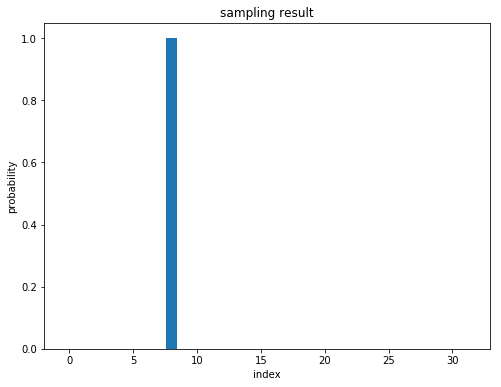

In [793]:
data = sampling_MCMC(onespinflip_gibbs, 3000, 20, 100)
disp_sampling_result_per_index(data)

In [794]:
# 取りうる状態の数え上げ（組み合わせ爆発に注意）
comb_all = list(itertools.product([-1,1], repeat=N))
comb_all_dict = {}
for c in comb_all:
    comb_all_dict[c] = 0

In [795]:
# 真の確率分布の表示（組み合わせ爆発に注意）
# 取りうる状態を[0,0,...,0]から[1,1,..,1]まで順に並べた際のインデックスを横軸（これ意味ある？）
def disp_GT_per_index(T = 1):
    ground_truth_prob = np.zeros(2**N)
    ground_truth_energy = np.zeros(2**N)
    for i, c in enumerate(comb_all):
        ground_truth_energy[i] = energy(np.array(c))
        ground_truth_prob[i] = np.exp(-ground_truth_energy[i] / T)
    ground_truth_prob = ground_truth_prob / np.sum(ground_truth_prob)
    plt.figure(figsize=(8,6))
    plt.title('ground truth')
    plt.xlabel('index')
    plt.ylabel('probability')
    plt.bar(np.arange(2**N), ground_truth_prob)
    plt.show()

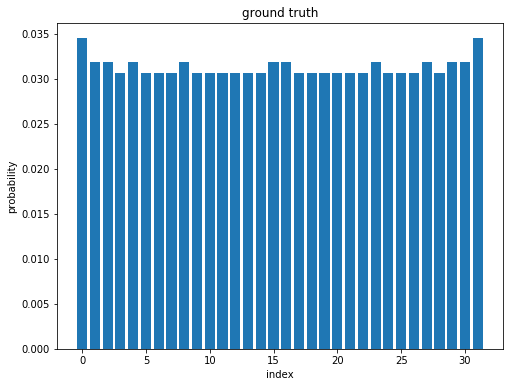

In [796]:
disp_GT_per_index()

In [740]:
# 真の確率分布の表示（組み合わせ爆発に注意）
# エネルギー横軸
def disp_GT_per_energy(T = 1):
    ground_truth_dict = {}
    for c in comb_all:
        temp_gt_energy = np.round(energy(np.array(c)), 5)
        if temp_gt_energy not in ground_truth_dict:
            ground_truth_dict[temp_gt_energy] = np.exp(-temp_gt_energy / T)
        else:
            ground_truth_dict[temp_gt_energy] += np.exp(-temp_gt_energy / T)
    ground_truth_energy = list(ground_truth_dict.keys())
    ground_truth_prob = list(ground_truth_dict.values())
    ground_truth_prob = ground_truth_prob / np.sum(ground_truth_prob)
    plt.figure(figsize=(8,6))
    plt.title('ground truth')
    plt.xlabel('energy')
    plt.ylabel('probability')
    plt.bar(ground_truth_energy, ground_truth_prob)
    plt.show()

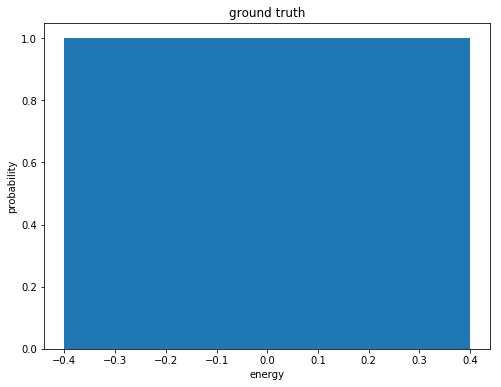

In [741]:
disp_GT_per_energy()

In [742]:
# サンプリング結果から導き出した確率分布の表示（組み合わせ爆発に注意）
# 取りうる状態を[0,0,...,0]から[1,1,..,1]まで順に並べた際のインデックスを横軸（これ意味ある？）
def disp_sampling_result_per_index(sampled_data):
    comb_all_dict = {}
    for c in comb_all:
        comb_all_dict[c] = 0
    for data in sampled_data:
        comb_all_dict[tuple(data)] += 1
    prob = np.array(list(comb_all_dict.values()))
    prob = prob / np.sum(prob)
    energy_gt = np.zeros(2**N)
    for i, c in enumerate(comb_all):
        energy_gt[i] = energy(np.array(c))
    plt.figure(figsize=(8,6))
    plt.title('sampling result')
    plt.xlabel('index')
    plt.ylabel('probability')
    plt.bar(np.arange(2**N), prob)
    plt.show()

elasped_time:  0.3544769287109375 [s]


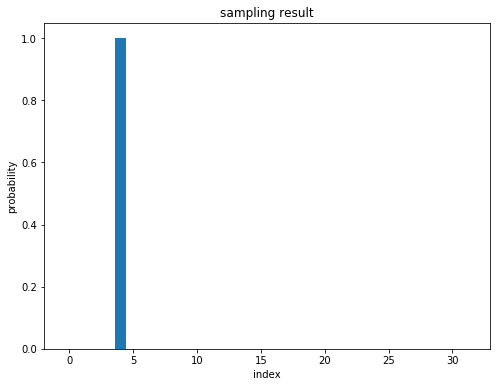

In [743]:
data = sampling_MCMC(onespinflip_gibbs, 1000, 10, 100, 5000)
disp_sampling_result_per_index(data)

In [715]:
# サンプリング結果から導き出した確率分布の表示（組み合わせ爆発に注意）
# エネルギー横軸
def disp_sampling_result_per_energy(sampled_data):
    result_dict = {}
    for s in sampled_data:
        temp_sampled_energy = np.round(energy(np.array(s)), 5)
        if temp_sampled_energy not in result_dict:
            result_dict[temp_sampled_energy] = 1
        else:
            result_dict[temp_sampled_energy] += 1
    print(result_dict)
    result_energy = list(result_dict.keys())
    print(result_energy)
    result_prob = list(result_dict.values())
    result_prob = result_prob / np.sum(result_prob)
    plt.figure(figsize=(8,6))
    plt.title('sampling result')
    plt.xlabel('energy')
    plt.ylabel('probability')
    plt.xlim([np.min(result_energy)-1, np.min(result_energy)+100])
    plt.bar(result_energy, result_prob)
    plt.show()

In [642]:
def KL_divergence(sampled_data, T = 1):
    ground_truth_prob_dict = {}
    sampled_prob_dict = {}
    for c in comb_all:
        ground_truth_prob_dict[c] = np.exp(-energy(c) / T)
        sampled_prob_dict[c] = 0
    for s in sampled_data:
        sampled_prob_dict[tuple(s)] += 1
    ground_truth_prob = list(ground_truth_prob_dict.values())
    ground_truth_prob = ground_truth_prob / np.sum(ground_truth_prob)
    sampled_prob = list(sampled_prob_dict.values())
    sampled_prob = sampled_prob / np.sum(sampled_prob)
    KL_div = 0
    for i in range(2**N):
        if sampled_prob[i] != 0:
            KL_div += sampled_prob[i] * np.log(sampled_prob[i] / ground_truth_prob[i])
    return KL_div

In [643]:
KL_divergence(data)

0.6948844259380189

In [641]:
data

[array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1]),
